In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, Select, RangeSlider, LinearAxis, Div, Span, CustomJS, RadioButtonGroup, Label, CheckboxGroup
from bokeh.layouts import column, row
from datetime import  datetime

import statsmodels

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

import matplotlib.dates as mdates

# Part I.1: Data Exploration and Basic Plots

## Context and Motivation
Before diving into complex analysis, we need to understand our data structure and create baseline visualizations. The COVID-19 dataset contains daily state-level observations, but national-level trends will help us identify overall patterns and the impact of the presidential transition on January 20, 2021.

---

## Exercise 1.1: Loading and Examining Data Structure

**Task:** Load the COVID dataset and explore its basic properties.

The dataset can downloaded [here](https://raw.githubusercontent.com/nytimes/covid-19-data/refs/heads/master/us-states.csv)

### Questions:
1. What is the date range of our dataset?
2. How many states are included?
3. Are those daily deaths ?
4. Are there any missing values or data quality issues?

In [2]:
df = pd.read_csv("us-states.csv", parse_dates=["date"])

# Examine structure
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

print("\nLast few rows:")
print(df.tail())

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Basic data exploration
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique states: {df['state'].nunique()}")
print(f"Total days: {df['date'].nunique()}")

# Basic statistics
print("\nBasic statistics for deaths:")
print(df['deaths'].describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (61942, 5)

Columns: ['date', 'state', 'fips', 'cases', 'deaths']

First few rows:
        date       state  fips  cases  deaths
0 2020-01-21  Washington    53      1       0
1 2020-01-22  Washington    53      1       0
2 2020-01-23  Washington    53      1       0
3 2020-01-24    Illinois    17      1       0
4 2020-01-24  Washington    53      1       0

Last few rows:
            date          state  fips    cases  deaths
61937 2023-03-23       Virginia    51  2298300   23782
61938 2023-03-23     Washington    53  1940704   15905
61939 2023-03-23  West Virginia    54   645710    8132
61940 2023-03-23      Wisconsin    55  2014524   16485
61941 2023-03-23        Wyoming    56   185800    2014

Date range: 2020-01-21 00:00:00 to 2023-03-23 00:00:00
Number of unique states: 56
Total days: 1158

Basic statistics for deaths:
count     61942.000000
mean      11779.067499
std       17345.774849
min           0.000000
25%        1171.000000
50%        5035.000000
75%       1

## Exercise 1.2: Calculate National Metrics

**Task:** Aggregate state data to national level and calculate derived metrics:
- daily deaths / cases
- moving 7 days average of daily deaths

### Questions:
1. How do you properly calculate daily death counts from cumulative data?
2. Why do we need 7-day moving averages?
3. What patterns do you observe in the raw daily data?

In [3]:
# Create national daily aggregates
national_data = df.groupby('date').agg({
    'cases': 'sum',
    'deaths': 'sum'
}).reset_index().sort_values('date')

###########################
# !!!!!!!!!!!!!!!!!!!!!!!!! DATA IS CUMULATIVE
###########################

# Data is cumulative, calculate daily differences
national_data['daily_deaths'] = national_data['deaths'].diff().fillna(0)
national_data['daily_cases'] = national_data['cases'].diff().fillna(0)

# Calculate 7-day moving averages
national_data['deaths_7day'] = national_data['daily_deaths'].rolling(
    window=7, center=True, min_periods=1
).mean()

national_data['cases_7day'] = national_data['daily_cases'].rolling(
    window=7, center=True, min_periods=1
).mean()

print("National data sample:")
print(national_data[['date', 'daily_deaths', 'deaths_7day']].head(10))

National data sample:
        date  daily_deaths  deaths_7day
0 2020-01-21           0.0          0.0
1 2020-01-22           0.0          0.0
2 2020-01-23           0.0          0.0
3 2020-01-24           0.0          0.0
4 2020-01-25           0.0          0.0
5 2020-01-26           0.0          0.0
6 2020-01-27           0.0          0.0
7 2020-01-28           0.0          0.0
8 2020-01-29           0.0          0.0
9 2020-01-30           0.0          0.0


## Exercise 1.3: Raw comparison
**Task:** Recreate the chart from The Economist/Reuters analysis but **showing cumulative deaths** with presidential periods highlighted.

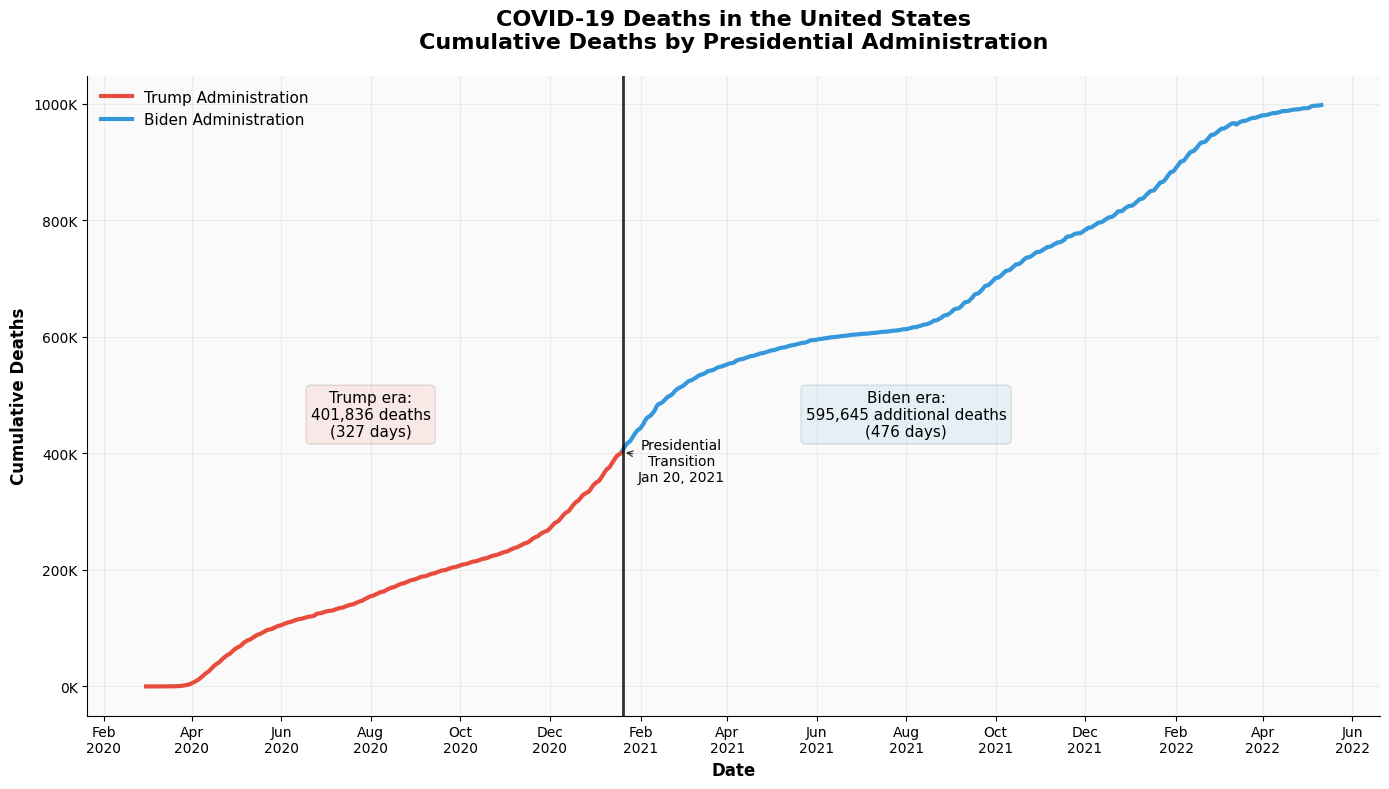

In [4]:
# Calculate cumulative deaths for the chart
national_data_sorted = national_data.sort_values('date').copy()
national_data_sorted['cumulative_deaths'] = national_data_sorted['daily_deaths'].cumsum()

# Define key periods
trump_start = datetime(2020, 3, 1)  # Pandemic start
transition_date = datetime(2021, 1, 20)
biden_analysis_end = datetime(2022, 5, 11)  # End date from analysis

# Filter data for the analysis period
chart_data = national_data_sorted[
    (national_data_sorted['date'] >= trump_start) & 
    (national_data_sorted['date'] <= biden_analysis_end)
].copy()

# Create The Economist-style visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors for presidential periods
trump_color = '#E74C3C'  # Red
biden_color = '#3498DB'  # Blue

# Plot cumulative deaths with period-specific colors
trump_data = chart_data[chart_data['date'] < transition_date]
biden_data = chart_data[chart_data['date'] >= transition_date]

# Trump period
ax.plot(trump_data['date'], trump_data['cumulative_deaths'], 
        color=trump_color, linewidth=3, label='Trump Administration')

# Biden period  
ax.plot(biden_data['date'], biden_data['cumulative_deaths'], 
        color=biden_color, linewidth=3, label='Biden Administration')

# Add presidential transition line
ax.axvline(x=transition_date, color='black', linestyle='-', 
           linewidth=2, alpha=0.8)

# Annotations for key statistics
trump_final_deaths = trump_data['cumulative_deaths'].iloc[-1]
biden_final_deaths = biden_data['cumulative_deaths'].iloc[-1]
biden_period_deaths = biden_final_deaths - trump_final_deaths

# Add text annotations
ax.annotate(f'Trump era:\n{trump_final_deaths:,.0f} deaths\n(327 days)', 
            xy=(datetime(2020, 8, 1), (trump_final_deaths + biden_final_deaths)/3),
            fontsize=11, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=trump_color, alpha=0.1))

ax.annotate(f'Biden era:\n{biden_period_deaths:,.0f} additional deaths\n({(biden_analysis_end - transition_date).days} days)', 
            xy=(datetime(2021, 8, 1), (trump_final_deaths + biden_final_deaths)/3),
            fontsize=11, ha='center', va='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=biden_color, alpha=0.1))

# Transition annotation
ax.annotate('Presidential\nTransition\nJan 20, 2021', 
            xy=(transition_date, trump_final_deaths),
            xytext=(datetime(2021, 3, 1), trump_final_deaths - 50000),
            arrowprops=dict(arrowstyle='->', color='black', alpha=0.7),
            fontsize=10, ha='center')

# Styling to match The Economist
ax.set_title('COVID-19 Deaths in the United States\nCumulative Deaths by Presidential Administration', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Deaths', fontsize=12, fontweight='bold')

# Format y-axis with thousands separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

# Format x-axis dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# Add subtle grid
ax.grid(True, alpha=0.2, linestyle='-')
ax.set_facecolor('#FAFAFA')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend
ax.legend(loc='upper left', fontsize=11, frameon=False)

plt.tight_layout()
plt.show()

# Part I.2: Comparative Visualizations

## Exercise 2.1: State-Level Comparisons

National aggregates hide important state-level variation. Different states experienced the pandemic at different times and with varying intensity. Understanding these patterns requires comparative visualization techniques and correlation analysis to reveal the relationship between cases and deaths with appropriate time lags.

**Task:** Identify and visualize the 5 states with the highest total deaths using small multiples.

**Questions:**

- Which states were most affected by COVID-19?
- Do these states show similar temporal patterns?


Top 5 states by total deaths:
state
California      104277
Texas            94518
Florida          87141
New York         80138
Pennsylvania     50701
Name: deaths, dtype: int64


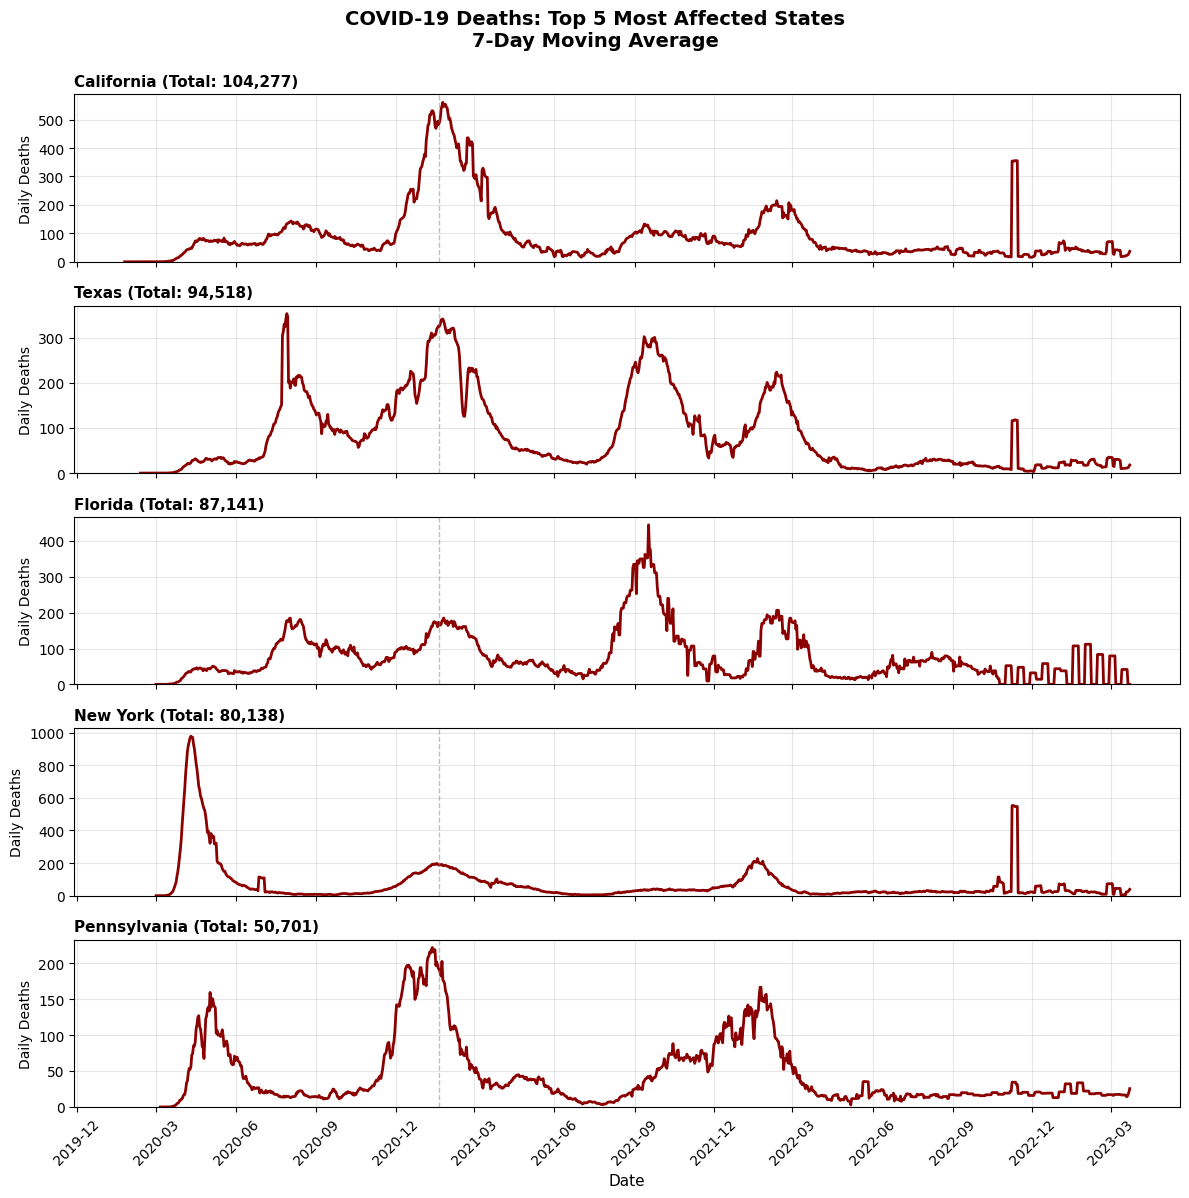

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Calculate total deaths by state
state_totals = df.groupby('state')['deaths'].max().sort_values(ascending=False)
top_5_states = state_totals.head(5).index.tolist()

print("Top 5 states by total deaths:")
print(state_totals.head(5))

# Prepare data for each state
fig, axes = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
fig.suptitle('COVID-19 Deaths: Top 5 Most Affected States\n7-Day Moving Average', 
             fontsize=14, fontweight='bold', y=0.995)

transition_date = datetime(2021, 1, 20)

for idx, state in enumerate(top_5_states):
    ax = axes[idx]
    
    # Get state data
    state_data = df[df['state'] == state].sort_values('date').copy()
    
    # Calculate daily deaths (if cumulative)
    state_data['daily_deaths'] = state_data['deaths'].diff().fillna(0).clip(lower=0)
    
    # Calculate 7-day moving average
    state_data['deaths_7day'] = state_data['daily_deaths'].rolling(
        window=7, center=True, min_periods=1
    ).mean()
    
    # Plot
    ax.plot(state_data['date'], state_data['deaths_7day'], 
            color='darkred', linewidth=2)
    
    # Add presidential transition line
    ax.axvline(x=transition_date, color='gray', linestyle='--', 
               linewidth=1, alpha=0.5)
    
    # Styling
    total_deaths = state_data['deaths'].max()
    ax.set_ylabel('Daily Deaths', fontsize=10)
    ax.set_title(f'{state} (Total: {total_deaths:,.0f})', 
                 fontsize=11, fontweight='bold', loc='left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)

# Format x-axis only on bottom plot
axes[-1].set_xlabel('Date', fontsize=11)
import matplotlib.dates as mdates
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Advantages of single graph:

- Direct comparison of magnitudes
- Direct comparison of magnitudes
- Easy to see which state had highest peaks
- Temporal alignment visible at a glance
- More compact presentation

### When to use small multiples instead:

- More than 4 lines (readability)
- Different scales needed per entity
- Focus on individual patterns rather than comparison
- Want to show more detail per entity

## Exercise 2.2: Cases vs Deaths Scatter Analysis

**Task:** Create a scatter plot to analyze the relationship between total cases and deaths across all states.

### Questions:
1. Is there a linear relationship between cases and deaths?
2. Which states are outliers (better or worse than expected)?
3. What might explain variation in case fatality rates?
4. How can we identify these patterns visually?

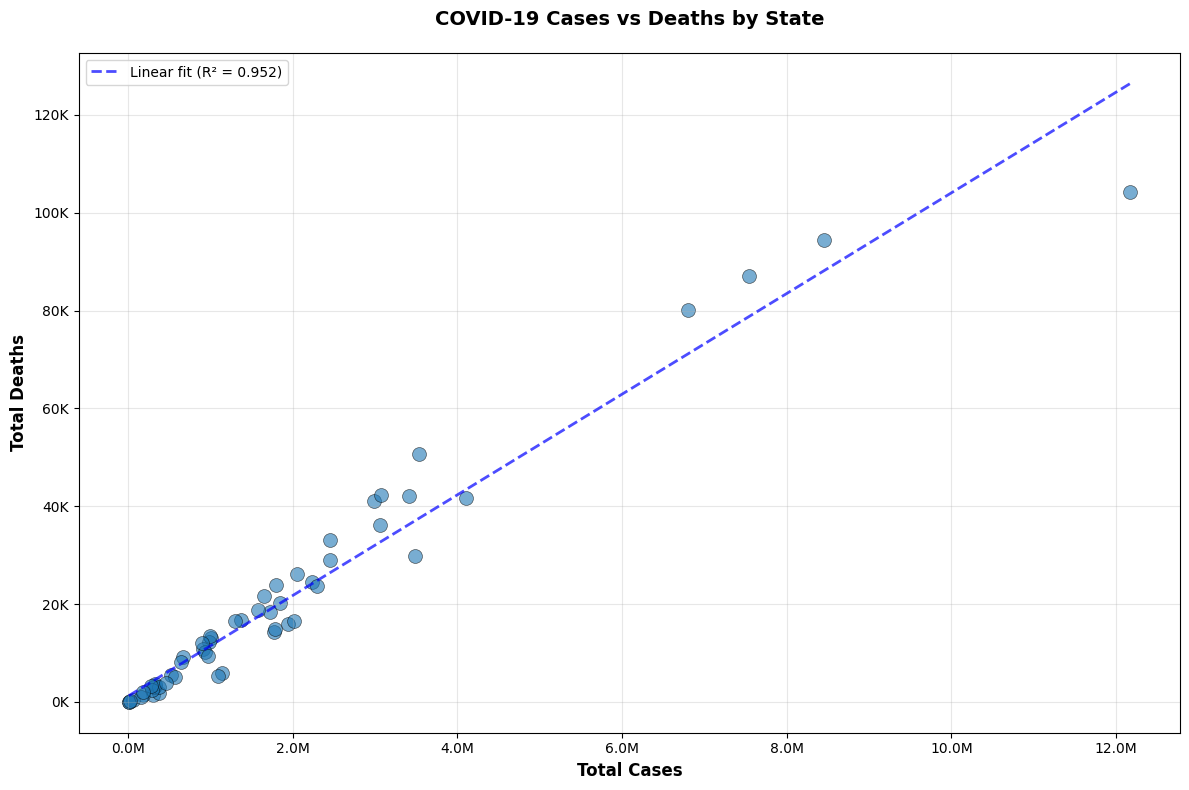

In [6]:

# Calculate state-level totals
state_summary = df.groupby('state').agg({
    'cases': 'max',
    'deaths': 'max'
}).reset_index()

# Calculate case fatality rate
state_summary['cfr'] = (state_summary['deaths'] / state_summary['cases'] * 100)

# Remove any states with zero cases (territories, data issues)
state_summary = state_summary[state_summary['cases'] > 0]

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Main scatter plot
scatter = ax.scatter(state_summary['cases'], state_summary['deaths'], 
                     s=100, alpha=0.6,
                      edgecolors='black', linewidth=0.5)
# cmap='RdYlGn_r', c=state_summary['cfr']
# Add colorbar for CFR
# cbar = plt.colorbar(scatter, ax=ax)
# cbar.set_label('Case Fatality Rate (%)', fontsize=11)

# Add linear regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    state_summary['cases'], state_summary['deaths']
)
x_line = np.array([state_summary['cases'].min(), state_summary['cases'].max()])
y_line = slope * x_line + intercept
ax.plot(x_line, y_line, 'b--', linewidth=2, alpha=0.7,
        label=f'Linear fit (R² = {r_value**2:.3f})')

# Annotate outliers (top 5 by deaths and highest/lowest CFR)
top_deaths = state_summary.nlargest(5, 'deaths')
high_cfr = state_summary.nlargest(3, 'cfr')
low_cfr = state_summary.nsmallest(3, 'cfr')

states_to_label = pd.concat([high_cfr, low_cfr]).drop_duplicates()


# Styling
ax.set_xlabel('Total Cases', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Deaths', fontsize=12, fontweight='bold')
ax.set_title('COVID-19 Cases vs Deaths by State', 
             fontsize=14, fontweight='bold', pad=20)

# Format axes with thousands separators
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))

ax.grid(True, alpha=0.3)
ax.legend(fontsize=10, loc='upper left')

plt.tight_layout()
plt.show()

# Print statistics
# print(f"\nCorrelation coefficient: {r_value:.3f}")
# print(f"R-squared: {r_value**2:.3f}")
# print(f"\nStates with highest CFR:")
# print(state_summary.nlargest(5, 'cfr')[['state', 'cfr']])
# print(f"\nStates with lowest CFR:")
# print(state_summary.nsmallest(5, 'cfr')[['state', 'cfr']])


# Part I.3: Statistical Analysis 


## Exercise 3.1: Death Rate Distributions by Administration

**Task:** Compare the distribution of daily death rates between Trump and Biden administrations using statistical visualizations.

### Questions:
1. What is the typical (median) daily death rate in each period?
2. How variable are death rates within each administration?
3. Are the distributions significantly different?

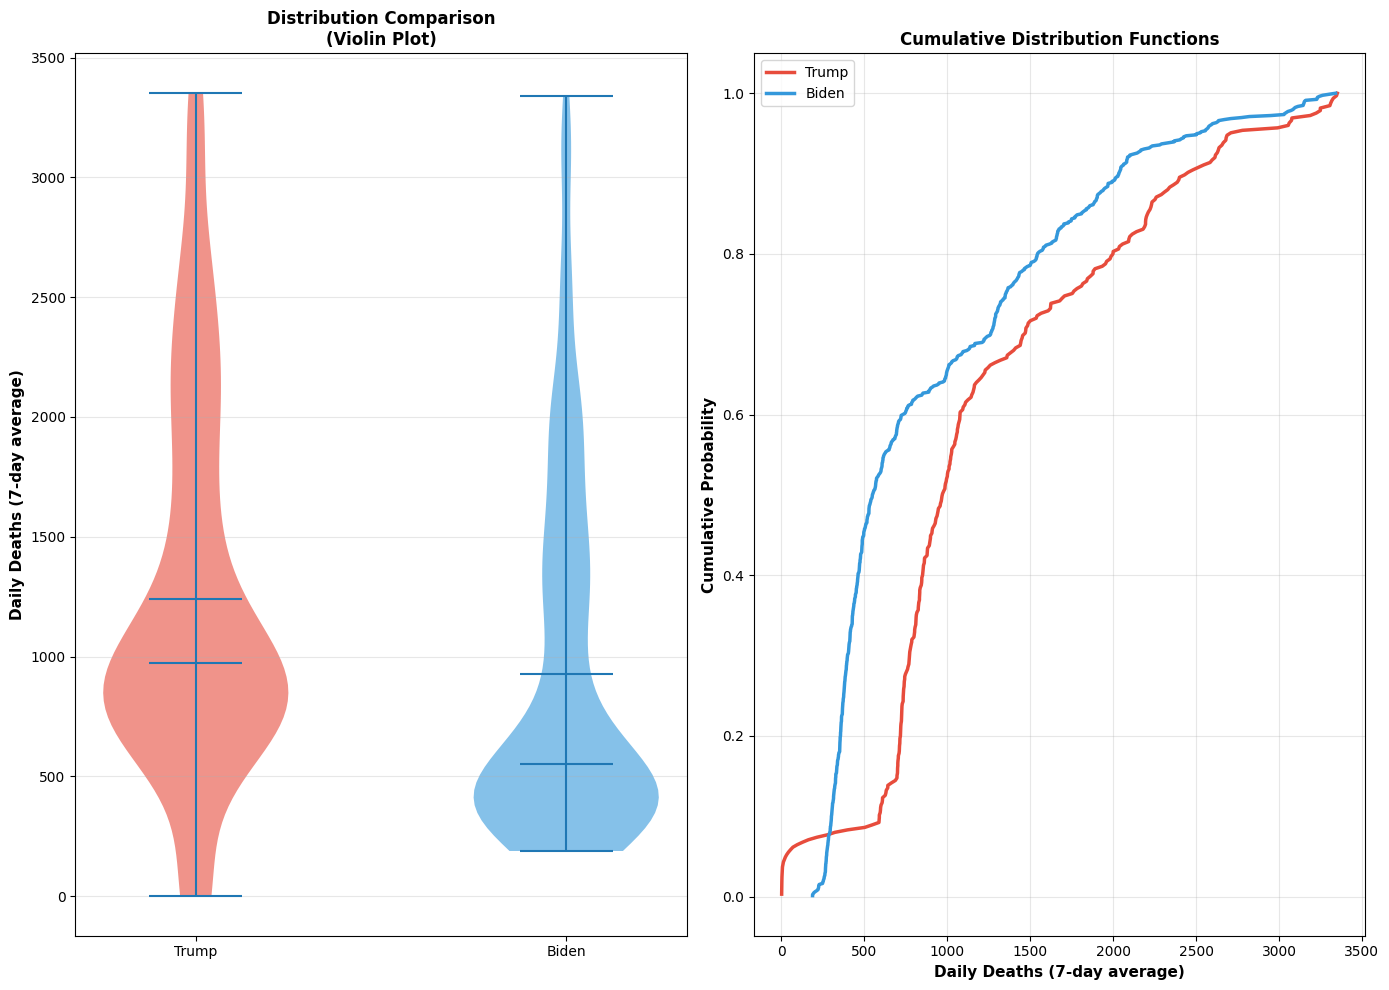

=== SUMMARY STATISTICS ===

Trump Administration (2020-03-01 to 2021-01-20):
  Duration: 325 days
  Mean daily deaths: 1242
  Median daily deaths: 972
  Std deviation: 791
  Min: 2
  Max: 3352
  25th percentile: 736
  75th percentile: 1754

Biden Administration (2021-01-20 onwards):
  Duration: 793 days
  Mean daily deaths: 926
  Median daily deaths: 549
  Std deviation: 741
  Min: 188
  Max: 3341
  25th percentile: 376
  75th percentile: 1352


In [7]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats

# Prepare national data
national = df.groupby('date').agg({
    'cases': 'sum',
    'deaths': 'sum'
}).reset_index().sort_values('date')

# Calculate daily deaths
national['daily_deaths'] = national['deaths'].diff().fillna(0).clip(lower=0)

# Calculate 7-day moving average
national['deaths_7day'] = national['daily_deaths'].rolling(
    window=7, center=True, min_periods=1
).mean()

# Define periods
trump_start = datetime(2020, 3, 1)
transition_date = datetime(2021, 1, 20)

# Split data by administration
trump_data = national[
    (national['date'] >= trump_start) & 
    (national['date'] < transition_date)
].copy()

biden_data = national[
    national['date'] >= transition_date
].copy()

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 10))

box_data = [
    trump_data['deaths_7day'].dropna(),
    biden_data['deaths_7day'].dropna()
]

# Colors
colors = ['#E74C3C', '#3498DB']

# Panel 1: Violin plots
ax1 = axes[0]
positions = [1, 2]
parts = ax1.violinplot(box_data, positions=positions, showmeans=True, showmedians=True)

for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.6)

ax1.set_xticks(positions)
ax1.set_xticklabels(['Trump', 'Biden'])
ax1.set_ylabel('Daily Deaths (7-day average)', fontsize=11, fontweight='bold')
ax1.set_title('Distribution Comparison\n(Violin Plot)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')



# Panel 2: Cumulative distribution functions
ax2 = axes[1]
trump_sorted = np.sort(trump_data['deaths_7day'].dropna())
biden_sorted = np.sort(biden_data['deaths_7day'].dropna())

trump_cdf = np.arange(1, len(trump_sorted) + 1) / len(trump_sorted)
biden_cdf = np.arange(1, len(biden_sorted) + 1) / len(biden_sorted)

ax2.plot(trump_sorted, trump_cdf, color=colors[0], linewidth=2.5, label='Trump')
ax2.plot(biden_sorted, biden_cdf, color=colors[1], linewidth=2.5, label='Biden')

ax2.set_xlabel('Daily Deaths (7-day average)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Cumulative Probability', fontsize=11, fontweight='bold')
ax2.set_title('Cumulative Distribution Functions', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=== SUMMARY STATISTICS ===\n")
print(f"Trump Administration ({trump_start.strftime('%Y-%m-%d')} to {transition_date.strftime('%Y-%m-%d')}):")
print(f"  Duration: {len(trump_data)} days")
print(f"  Mean daily deaths: {trump_data['deaths_7day'].mean():.0f}")
print(f"  Median daily deaths: {trump_data['deaths_7day'].median():.0f}")
print(f"  Std deviation: {trump_data['deaths_7day'].std():.0f}")
print(f"  Min: {trump_data['deaths_7day'].min():.0f}")
print(f"  Max: {trump_data['deaths_7day'].max():.0f}")
print(f"  25th percentile: {trump_data['deaths_7day'].quantile(0.25):.0f}")
print(f"  75th percentile: {trump_data['deaths_7day'].quantile(0.75):.0f}")

print(f"\nBiden Administration ({transition_date.strftime('%Y-%m-%d')} onwards):")
print(f"  Duration: {len(biden_data)} days")
print(f"  Mean daily deaths: {biden_data['deaths_7day'].mean():.0f}")
print(f"  Median daily deaths: {biden_data['deaths_7day'].median():.0f}")
print(f"  Std deviation: {biden_data['deaths_7day'].std():.0f}")
print(f"  Min: {biden_data['deaths_7day'].min():.0f}")
print(f"  Max: {biden_data['deaths_7day'].max():.0f}")
print(f"  25th percentile: {biden_data['deaths_7day'].quantile(0.25):.0f}")
print(f"  75th percentile: {biden_data['deaths_7day'].quantile(0.75):.0f}")


## Introduction to Bokeh Architecture

### Key Concepts:
1. **ColumnDataSource**: Central data structure that enables reactive updates
2. **Widgets**: Interactive controls (dropdowns, sliders, buttons)
3. **Callbacks**: Functions that execute when widgets change
4. **Layouts**: Organize plots and widgets (row, column, gridplot)
5. **Tools**: Built-in interactivity (hover, pan, zoom, reset)

### Basic Pattern:
```
Data → ColumnDataSource → Plot → Widget → Callback → Update ColumnDataSource → Plot Updates
```

---

## Exercise 3.2: Building the Interactive Data Explorer 

**Task:** Create an interactive dashboard for exploring COVID-19 data by state and time period.

### Objectives:
1. **State selector**: Dropdown to choose any state or "National"
2. **Date range slider**: Select time period to analyze
5. **Interactive tools**: Hover tooltips, zoom, pan, reset

Proceed step by step ! Otherwise you will drown...

In [8]:

# For Jupyter notebook
output_notebook()

# Prepare data
df['date'] = pd.to_datetime(df['date'])

# Create state-level aggregates
state_data = df.groupby(['state', 'date']).agg({
    'cases': 'sum',
    'deaths': 'sum'
}).reset_index().sort_values(['state', 'date'])

# Calculate daily values
state_data['daily_cases'] = state_data.groupby('state')['cases'].diff().fillna(0).clip(lower=0)
state_data['daily_deaths'] = state_data.groupby('state')['deaths'].diff().fillna(0).clip(lower=0)

# Calculate 7-day moving averages
state_data['cases_7day'] = state_data.groupby('state')['daily_cases'].transform(
    lambda x: x.rolling(7, center=True, min_periods=1).mean()
)
state_data['deaths_7day'] = state_data.groupby('state')['daily_deaths'].transform(
    lambda x: x.rolling(7, center=True, min_periods=1).mean()
)

# Add national aggregate
national_data = df.groupby('date').agg({
    'cases': 'sum',
    'deaths': 'sum'
}).reset_index().sort_values('date')
national_data['state'] = 'National'
national_data['daily_cases'] = national_data['cases'].diff().fillna(0).clip(lower=0)
national_data['daily_deaths'] = national_data['deaths'].diff().fillna(0).clip(lower=0)
national_data['cases_7day'] = national_data['daily_cases'].rolling(7, center=True, min_periods=1).mean()
national_data['deaths_7day'] = national_data['daily_deaths'].rolling(7, center=True, min_periods=1).mean()

# Combine
full_data = pd.concat([state_data, national_data], ignore_index=True)

# Convert dates to numeric (days since start) for slider
min_date = full_data['date'].min()
max_date = full_data['date'].max()
full_data['days_since_start'] = (full_data['date'] - min_date).dt.days

# Store ALL data in a ColumnDataSource
full_source = ColumnDataSource(full_data)

# Initial display data (National, full period)
initial_data = full_data[full_data['state'] == 'National'].copy()
display_source = ColumnDataSource(data={
    'date': initial_data['date'],
    'deaths_7day': initial_data['deaths_7day'],
    'cases_7day': initial_data['cases_7day'],
    'daily_deaths': initial_data['daily_deaths'],
    'daily_cases': initial_data['daily_cases']
})

# Create figure
p = figure(
    title='COVID-19 Deaths - National',
    x_axis_label='Date',
    y_axis_label='Daily Deaths (7-day average)',
    x_axis_type='datetime',
    width=900,
    height=450,
    tools='pan,wheel_zoom,box_zoom,reset,save'
)

# Add line
line = p.line('date', 'deaths_7day', source=display_source, 
              line_width=3, color='darkred', alpha=0.8)

# Add presidential transition line
transition_date = datetime(2021, 1, 20)

transition_line = Span(location=transition_date, dimension='height',
                       line_color='blue', line_dash='dashed', line_width=2, line_alpha=0.6)
p.add_layout(transition_line)

# Add hover tool
from bokeh.models import HoverTool
hover = HoverTool(
    tooltips=[
        ('Date', '@date{%F}'),
        ('Deaths (7-day)', '@deaths_7day{0,0.0}'),
        ('Cases (7-day)', '@cases_7day{0,0.0}'),
    ],
    formatters={'@date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

# Style
p.title.text_font_size = '14pt'
p.title.align = 'center'
p.xgrid.grid_line_alpha = 0.3
p.ygrid.grid_line_alpha = 0.3

# Create widgets
# 1. State selector
states_list = ['National'] + sorted(full_data[full_data['state'] != 'National']['state'].unique().tolist())
state_select = Select(
    title='Select State:',
    value='National',
    options=states_list,
    width=300
)

# 2. Time period slider
total_days = (max_date - min_date).days
date_slider = RangeSlider(
    title='Time Period (days since March 2020):',
    start=0,
    end=total_days,
    value=(0, total_days),
    step=1,
    width=600
)

# JavaScript callback
callback = CustomJS(args=dict(
    source=display_source, 
    full_source=full_source, 
    plot=p, 
    state_select=state_select,
    date_slider=date_slider,
    min_date_ms=min_date.value // 10**6,  # Convert to milliseconds for JS
    transition_date_ms=transition_date.timestamp() * 1000
), code="""
    // Get selected values
    const selected_state = state_select.value;
    const [start_day, end_day] = date_slider.value;
    const metric_idx = 0;
    const metric = metric_idx === 0 ? 'deaths_7day' : 'cases_7day';
    const metric_label = metric_idx === 0 ? 'Deaths' : 'Cases';
    const daily_metric = metric_idx === 0 ? 'daily_deaths' : 'daily_cases';
    
    // Get all data
    const full_data = full_source.data;
    const states = full_data['state'];
    const days = full_data['days_since_start'];
    
    // Filter by state AND date range
    const filtered_indices = [];
    for (let i = 0; i < states.length; i++) {
        if (states[i] === selected_state && 
            days[i] >= start_day && 
            days[i] <= end_day) {
            filtered_indices.push(i);
        }
    }
    
    // Extract filtered data
    const new_data = {
        date: [],
        deaths_7day: [],
        cases_7day: [],
        daily_deaths: [],
        daily_cases: []
    };
    
    let sum_deaths = 0;
    let sum_cases = 0;
    let max_deaths = 0;
    let max_cases = 0;
    let count = 0;
    
    for (let i of filtered_indices) {
        new_data.date.push(full_data['date'][i]);
        new_data.deaths_7day.push(full_data['deaths_7day'][i]);
        new_data.cases_7day.push(full_data['cases_7day'][i]);
        new_data.daily_deaths.push(full_data['daily_deaths'][i]);
        new_data.daily_cases.push(full_data['daily_cases'][i]);
        
        // Calculate statistics
        sum_deaths += full_data['daily_deaths'][i];
        sum_cases += full_data['daily_cases'][i];
        if (full_data['deaths_7day'][i] > max_deaths) max_deaths = full_data['deaths_7day'][i];
        if (full_data['cases_7day'][i] > max_cases) max_cases = full_data['cases_7day'][i];
        count++;
    }
    
    // Update display source
    source.data = new_data;
    
    // Update plot title and axis
    plot.title.text = 'COVID-19 ' + metric_label + ' - ' + selected_state;
    plot.yaxis.axis_label = 'Daily ' + metric_label + ' (7-day average)';
    

    // Convert day numbers to dates for display
    const start_date = new Date(min_date_ms + start_day * 86400000);
    const end_date = new Date(min_date_ms + end_day * 86400000);
    const start_str = start_date.toISOString().split('T')[0];
    const end_str = end_date.toISOString().split('T')[0];
    
    // Trigger update
    source.change.emit();
""")

# Attach callbacks to all widgets
state_select.js_on_change('value', callback)
date_slider.js_on_change('value', callback)

# Create layout
controls_top = row(state_select, )
layout = column(
    controls_top,
    date_slider,
    row(p,)
)

# Show
show(layout)

Loading BokehJS ...


### Key JavaScript Concepts:

**Accessing slider range values:**
```javascript
const [start_day, end_day] = date_slider.value;  // Array destructuring
```

**Filtering by multiple conditions:**
```javascript
if (states[i] === selected_state && 
    days[i] >= start_day && 
    days[i] <= end_day) {
    filtered_indices.push(i);
}
```

**Calculating statistics during filtering:**
```javascript
for (let i of filtered_indices) {
    sum_deaths += full_data['daily_deaths'][i];
    count++;
}
const avg_deaths = count > 0 ? (sum_deaths / count).toFixed(0) : 0;
```

**Date conversion for display:**
```javascript
const start_date = new Date(min_date_ms + start_day * 86400000);
const start_str = start_date.toISOString().split('T')[0];
```



### Common Issues and Solutions:

**Issue 1: "Slider moves but plot doesn't update"**
- Check: Is callback attached with `js_on_change('value', callback)`?
- Check: Are you filtering by `days_since_start` correctly?
- Debug: Add `console.log(start_day, end_day)` in JavaScript

**Issue 2: "Statistics show NaN or weird values"**
- Check: Is `count > 0` before dividing?
- Check: Are you accumulating sums correctly in loop?
- Debug: Log `sum_deaths` and `count` values

**Issue 3: "Date display shows wrong dates"**
- Check: Is `min_date_ms` in milliseconds?
- Check: Multiply days by `86400000` (ms per day)
- Debug: Log converted date strings

**Issue 4: "Slider range doesn't make sense"**
- Check: Calculate total_days correctly with `.days` attribute
- Check: Slider end value matches data range
- Debug: Print `total_days` in Python


# Part III: Presidential Analysis Dashboard

Parts I and II showed that raw statistics appear similar between administrations, but contexts were dramatically different. This section teaches sophisticated decomposition methods to adjust for confounding factors: vaccine availability, variant severity, seasonal patterns, and inherited conditions. Students will build an interactive dashboard that reveals whether performance differences persist after contextual adjustment.



## Part III.2: Trend Decomposition Engine

**Task:** Decompose the death rate time series into trend, seasonal, and residual components to isolate administration performance.

Use `from statsmodels.tsa.seasonal import STL`

What systematic patterns should we remove before comparing?

In [9]:
from statsmodels.tsa.seasonal import STL


# output_notebook()

# Prepare data - use RAW daily deaths
national_raw = national[
    (national['date'] >= trump_start) & 
    (national['daily_deaths'].notna())
].copy()

decomp_data = national_raw.set_index('date')

# ==== TWO-STAGE DECOMPOSITION on RAW data ====
# Stage 1: Extract weekly seasonality
stl_weekly = STL(
    decomp_data['daily_deaths'],
    seasonal=7,
    period=7,
    trend=None
)
result_weekly = stl_weekly.fit()
weekly_seasonal = result_weekly.seasonal
detrended_weekly = decomp_data['daily_deaths'] - weekly_seasonal

# Stage 2: Extract annual seasonality with moderate trend
stl_annual = STL(
    detrended_weekly,
    seasonal=53,
    period=7,
    trend=91
)
result_annual = stl_annual.fit()

annual_seasonal = result_annual.seasonal
trend = result_annual.trend
residual = result_annual.resid

# Total seasonal
total_seasonal = weekly_seasonal + annual_seasonal
reconstructed = trend + total_seasonal + residual

print("=== DECOMPOSITION CHECK ===")
print(f"Using RAW daily deaths (not 7-day average)")
print(f"Max reconstruction error: {abs(decomp_data['daily_deaths'] - reconstructed).max():.2f}")

# Define major events INCLUDING political events
events = [
    {'date': datetime(2020, 3, 11), 'label': 'WHO Pandemic', 'color': '#e74c3c', 'type': 'health'},
    {'date': datetime(2020, 3, 27), 'label': 'CARES Act', 'color': '#8e44ad', 'type': 'political'},
    {'date': datetime(2020, 11, 3), 'label': 'Election Day', 'color': '#8e44ad', 'type': 'political'},
    {'date': datetime(2020, 12, 14), 'label': 'First Vaccine', 'color': '#27ae60', 'type': 'health'},
    {'date': transition_date, 'label': 'Transition', 'color': '#3498db', 'type': 'transition'},
    {'date': datetime(2021, 3, 11), 'label': 'Stimulus Bill', 'color': '#8e44ad', 'type': 'political'},
    {'date': datetime(2021, 7, 1), 'label': 'Delta Wave', 'color': '#e67e22', 'type': 'health'},
    {'date': datetime(2021, 12, 1), 'label': 'Omicron', 'color': '#9b59b6', 'type': 'health'},
]

# Create ColumnDataSources
source_original = ColumnDataSource(data={
    'date': decomp_data.index,
    'value': decomp_data['daily_deaths'].values
})

source_trend = ColumnDataSource(data={
    'date': decomp_data.index,
    'value': trend.values
})

source_weekly = ColumnDataSource(data={
    'date': decomp_data.index,
    'value': weekly_seasonal.values
})

source_annual = ColumnDataSource(data={
    'date': decomp_data.index,
    'value': annual_seasonal.values
})

source_total_seasonal = ColumnDataSource(data={
    'date': decomp_data.index,
    'value': total_seasonal.values
})

source_residual = ColumnDataSource(data={
    'date': decomp_data.index,
    'value': residual.values
})

# Create figure
p = figure(
    title='RAW Daily Deaths Decomposition with Health & Political Events',
    x_axis_type='datetime',
    width=1100,
    height=550,
    tools='pan,wheel_zoom,box_zoom,reset,save'
)

# Plot components
line_original = p.line('date', 'value', source=source_original, 
                       line_width=1.5, color='#2c3e50', alpha=0.7, 
                       legend_label='📊 Raw Daily Deaths', visible=True)

line_trend = p.line('date', 'value', source=source_trend, 
                    line_width=3, color='#e74c3c', alpha=0.9, 
                    legend_label='📈 Trend (90 days)', visible=True)

line_weekly = p.line('date', 'value', source=source_weekly, 
                     line_width=1.5, color='#3498db', alpha=0.8,
                     legend_label='📅 Weekly Pattern', visible=True)

line_annual = p.line('date', 'value', source=source_annual, 
                     line_width=2, color='#27ae60', alpha=0.8,
                     legend_label='❄️ Annual (Winter/Summer)', visible=False)

line_total_seasonal = p.line('date', 'value', source=source_total_seasonal,
                             line_width=2, color='#16a085', alpha=0.7, line_dash='dashed',
                             legend_label='🌊 Total Seasonal', visible=False)

line_residual = p.line('date', 'value', source=source_residual, 
                       line_width=1.5, color='#9b59b6', alpha=0.8,
                       legend_label='🎯 Residual', visible=True)

# Add event markers
for event in events:
    # Different line style for political events
    if event['type'] == 'political':
        line_dash = 'dotted'
        line_width = 2
    elif event['type'] == 'transition':
        line_dash = 'dashed'
        line_width = 3
    else:
        line_dash = 'dotted'
        line_width = 1.5
    
    span = Span(
        location=event['date'],
        dimension='height',
        line_color=event['color'],
        line_dash=line_dash,
        line_width=line_width,
        line_alpha=0.7
    )
    p.add_layout(span)
    
    # Label
    label = Label(
        x=event['date'],
        y=4500,
        text=event['label'],
        text_font_size='8pt',
        text_color=event['color'],
        text_alpha=0.9,
        angle=90,
        angle_units='deg',
        text_baseline='bottom',
        text_align='left'
    )
    p.add_layout(label)

# Zero line
zero_span = Span(location=0, dimension='width', line_color='gray', 
                 line_dash='solid', line_width=1, line_alpha=0.3)
p.add_layout(zero_span)

# Style
p.yaxis.axis_label = 'Daily Deaths (RAW, not smoothed)'
p.xaxis.axis_label = 'Date'
p.title.text_font_size = '12pt'
p.title.align = 'center'
p.xgrid.grid_line_alpha = 0.3
p.ygrid.grid_line_alpha = 0.3

# Legend
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.legend.background_fill_alpha = 0.95

# Hover
hover = HoverTool(
    tooltips=[
        ('Date', '@date{%F}'),
        ('Deaths', '@value{0,0}')
    ],
    formatters={'@date': 'datetime'},
    mode='vline'
)
p.add_tools(hover)

# Checkboxes
checkbox = CheckboxGroup(
    labels=['📊 Raw Deaths', '📈 Trend', '📅 Weekly', '❄️ Annual', '🌊 Total Seasonal', '🎯 Residual'],
    active=[0, 1, 2, 5],
    width=600
)

# JavaScript callback
callback = CustomJS(args=dict(
    line_original=line_original,
    line_trend=line_trend,
    line_weekly=line_weekly,
    line_annual=line_annual,
    line_total_seasonal=line_total_seasonal,
    line_residual=line_residual,
    checkbox=checkbox
), code="""
    const active = checkbox.active;
    
    line_original.visible = active.includes(0);
    line_trend.visible = active.includes(1);
    line_weekly.visible = active.includes(2);
    line_annual.visible = active.includes(3);
    line_total_seasonal.visible = active.includes(4);
    line_residual.visible = active.includes(5);
""")

checkbox.js_on_change('active', callback)

# Statistics
trump_residuals = residual[residual.index < transition_date]
biden_residuals = residual[residual.index >= transition_date]

from scipy.stats import ttest_ind, mannwhitneyu
t_stat, p_val = ttest_ind(trump_residuals.dropna(), biden_residuals.dropna())
u_stat, u_pval = mannwhitneyu(trump_residuals.dropna(), biden_residuals.dropna())

weekly_amp = weekly_seasonal.max() - weekly_seasonal.min()
annual_amp = annual_seasonal.max() - annual_seasonal.min()



# Layout
layout = column(
    p,
    row(column(checkbox, width=600), )
)

show(layout)

print("=== EVENTS ADDED ===")
print("\nHealth Events:")
print("  - WHO Pandemic (Mar 11, 2020)")
print("  - First Vaccine (Dec 14, 2020)")
print("  - Delta Wave (Jul 1, 2021)")
print("  - Omicron (Dec 1, 2021)")
print("\nPolitical Events:")
print("  - CARES Act (Mar 27, 2020) - $2T stimulus")
print("  - Election Day (Nov 3, 2020)")
print("  - American Rescue Plan (Mar 11, 2021) - $1.9T stimulus")
print("\nTransition:")
print("  - Jan 20, 2021 (blue dashed line)")

=== DECOMPOSITION CHECK ===
Using RAW daily deaths (not 7-day average)
Max reconstruction error: 0.00


=== EVENTS ADDED ===

Health Events:
  - WHO Pandemic (Mar 11, 2020)
  - First Vaccine (Dec 14, 2020)
  - Delta Wave (Jul 1, 2021)
  - Omicron (Dec 1, 2021)

Political Events:
  - CARES Act (Mar 27, 2020) - $2T stimulus
  - Election Day (Nov 3, 2020)
  - American Rescue Plan (Mar 11, 2021) - $1.9T stimulus

Transition:
  - Jan 20, 2021 (blue dashed line)


## Optional : Time-Lagged Correlation Analysis

**Task:** Analyze the relationship between cases and deaths with time lags to understand the delay between infection and mortality.

### Questions:
1. What is the typical lag between case surges and death surges?
2. How do we calculate correlation with time shifts?
3. Did this lag change over time (better treatments, vaccines)?
4. What does the correlation function tell us about pandemic dynamics?


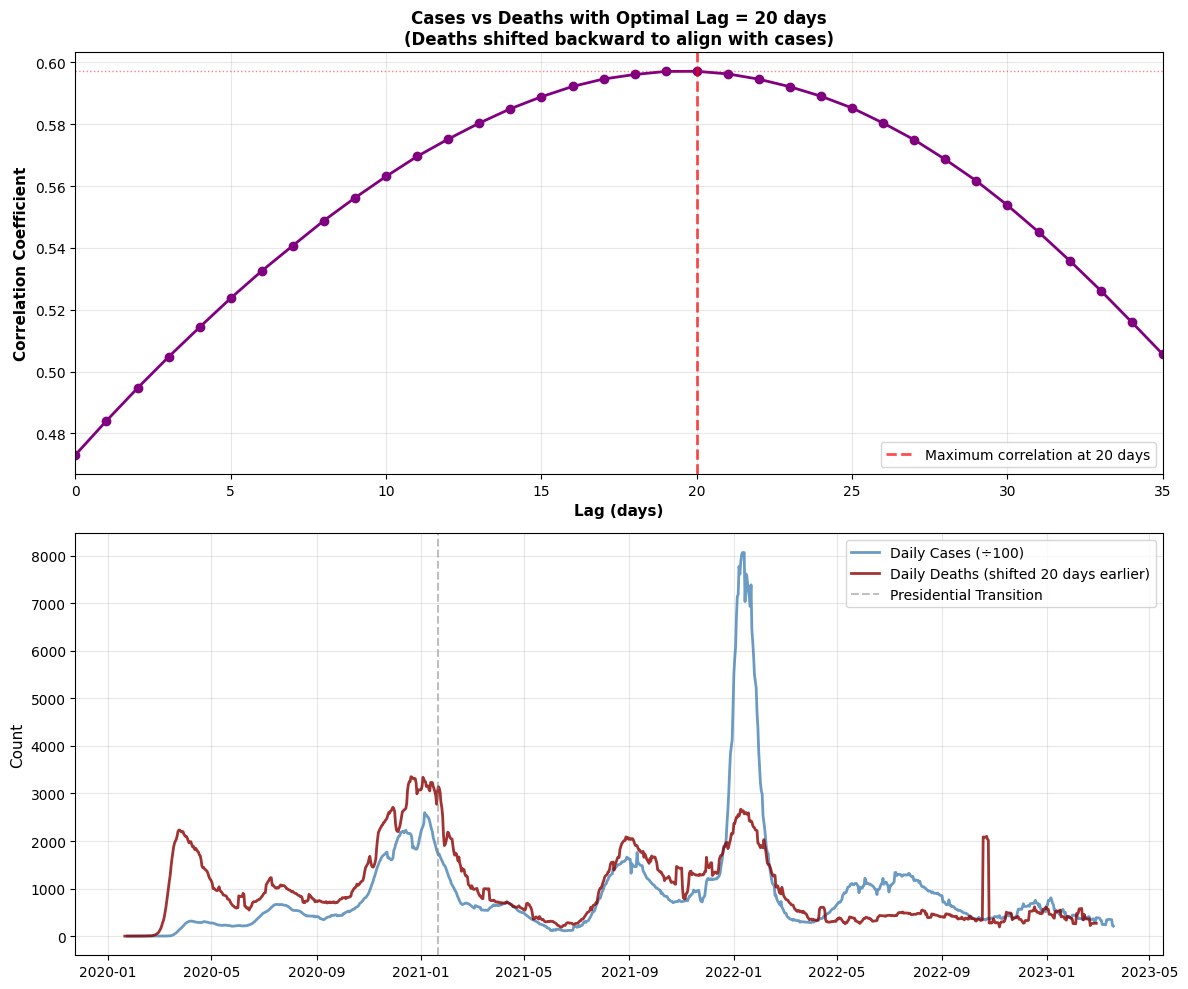

Optimal lag between cases and deaths: 20 days
Maximum correlation: 0.597

Interpretation: Deaths typically occur ~20 days after case detection


In [10]:
# Use national data for cleaner signal
national = df.groupby('date').agg({
    'cases': 'sum',
    'deaths': 'sum'
}).reset_index().sort_values('date')

# Calculate daily values
national['daily_cases'] = national['cases'].diff().fillna(0).clip(lower=0)
national['daily_deaths'] = national['deaths'].diff().fillna(0).clip(lower=0)

# Smooth with 7-day average
national['cases_smooth'] = national['daily_cases'].rolling(7, center=True).mean()
national['deaths_smooth'] = national['daily_deaths'].rolling(7, center=True).mean()

# Calculate cross-correlation for different lags
max_lag = 35  # Check up to 5 weeks
lags = range(0, max_lag + 1)
correlations = []

for lag in lags:
    # Shift deaths backward (positive lag means deaths follow cases)
    deaths_shifted = national['deaths_smooth'].shift(-lag)
    
    # Calculate correlation on overlapping data
    valid_mask = deaths_shifted.notna() & national['cases_smooth'].notna()
    if valid_mask.sum() > 30:  # Need enough data points
        corr = national.loc[valid_mask, 'cases_smooth'].corr(
            deaths_shifted[valid_mask]
        )
        correlations.append(corr)
    else:
        correlations.append(np.nan)

# Find optimal lag
optimal_lag = lags[np.nanargmax(correlations)]
max_corr = np.nanmax(correlations)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))



# Panel 1: Correlation function
ax1.plot(lags, correlations, 'o-', color='purple', linewidth=2, markersize=6)
ax1.axvline(x=optimal_lag, color='red', linestyle='--', 
            linewidth=2, alpha=0.7,
            label=f'Maximum correlation at {optimal_lag} days')
ax1.axhline(y=max_corr, color='red', linestyle=':', 
            linewidth=1, alpha=0.5)

ax1.set_xlabel('Lag (days)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Correlation Coefficient', fontsize=11, fontweight='bold')
ax1.set_title(f'Correlation: Cases vs Deaths\nMaximum Correlation = {max_corr:.3f} at {optimal_lag} days', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, max_lag)

# Panel 2: Time series with optimal lag
ax2.plot(national['date'], national['cases_smooth'] / 100,  # Scale down for visualization
         color='steelblue', linewidth=2, label='Daily Cases (÷100)', alpha=0.8)

deaths_shifted_optimal = national['deaths_smooth'].shift(-optimal_lag)
ax2.plot(national['date'], deaths_shifted_optimal,
         color='darkred', linewidth=2, label=f'Daily Deaths (shifted {optimal_lag} days earlier)', 
         alpha=0.8)

ax2.axvline(x=transition_date, color='gray', linestyle='--', 
            linewidth=1.5, alpha=0.5, label='Presidential Transition')

ax2.set_ylabel('Count', fontsize=11)
ax1.set_title(f'Cases vs Deaths with Optimal Lag = {optimal_lag} days\n(Deaths shifted backward to align with cases)', 
              fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


print(f"Optimal lag between cases and deaths: {optimal_lag} days")
print(f"Maximum correlation: {max_corr:.3f}")
print("\nInterpretation: Deaths typically occur ~{} days after case detection".format(optimal_lag))

# Challenge

Make the graph above with bokeh so that the reader can visually estimate which lag seems better to them. The lag should be dynamic, set by a slider.